In [7]:
import os
import pandas as pd
import numpy as np
import librosa
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
def extract_features(audio_path):
    """Enhanced feature extraction"""
    y, sr = librosa.load(audio_path, sr=16000)
    
    # 1. MFCCs (40 coefficients)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfccs_mean = np.mean(mfccs, axis=1)
    mfccs_std = np.std(mfccs, axis=1)
    mfccs_max = np.max(mfccs, axis=1)
    mfccs_min = np.min(mfccs, axis=1)
    
    # 2. Spectral features
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    
    # 3. Temporal features
    zcr = librosa.feature.zero_crossing_rate(y)
    
    # 4. Chroma features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    
    # 5. Tempo and rhythm
    tempo = librosa.beat.tempo(y=y, sr=sr)
    
    # Aggregate all features
    features = np.concatenate([
        mfccs_mean,
        mfccs_std,
        mfccs_max,
        mfccs_min,
        [np.mean(spectral_centroid), np.std(spectral_centroid)],
        [np.mean(spectral_rolloff), np.std(spectral_rolloff)],
        [np.mean(spectral_contrast), np.std(spectral_contrast)],
        [np.mean(spectral_bandwidth), np.std(spectral_bandwidth)],
        [np.mean(zcr), np.std(zcr)],
        [np.mean(chroma), np.std(chroma)],
        tempo
    ])
    
    return features

In [9]:
def load_all_audio_features(base_path):
    """Load all audio files"""
    features_list = []
    labels = []
    filenames = []
    languages = []
    
    # Load AI voices
    print("\n📂 Loading AI voices...")
    ai_path = os.path.join(base_path, 'ai')
    count_ai = 0
    for lang_folder in os.listdir(ai_path):
        lang_path = os.path.join(ai_path, lang_folder)
        if os.path.isdir(lang_path):
            for audio_file in os.listdir(lang_path):
                if audio_file.endswith('.mp3'):
                    file_path = os.path.join(lang_path, audio_file)
                    try:
                        features = extract_features(file_path)
                        features_list.append(features)
                        labels.append(1)
                        filenames.append(audio_file)
                        languages.append(lang_folder.lower())
                        count_ai += 1
                        if count_ai % 10 == 0:
                            print(f"   Loaded {count_ai} AI samples...")
                    except Exception as e:
                        print(f"   ✗ Error with {audio_file}: {e}")
    
    # Load Human voices
    print(f"\n📂 Loading Human voices...")
    human_path = os.path.join(base_path, 'human')
    count_human = 0
    for lang_folder in os.listdir(human_path):
        lang_path = os.path.join(human_path, lang_folder)
        if os.path.isdir(lang_path):
            for audio_file in os.listdir(lang_path):
                if audio_file.endswith('.mp3'):
                    file_path = os.path.join(lang_path, audio_file)
                    try:
                        features = extract_features(file_path)
                        features_list.append(features)
                        labels.append(0)
                        filenames.append(audio_file)
                        languages.append(lang_folder.lower())
                        count_human += 1
                        if count_human % 10 == 0:
                            print(f"   Loaded {count_human} Human samples...")
                    except Exception as e:
                        print(f"   ✗ Error with {audio_file}: {e}")
    
    df = pd.DataFrame(features_list)
    df['label'] = labels
    df['filename'] = filenames
    df['language'] = languages
    
    print("\n" + "="*60)
    print(f"✅ DATASET LOADED")
    print(f"   Total samples: {len(df)}")
    print(f"   AI samples: {sum(labels)}")
    print(f"   Human samples: {len(labels) - sum(labels)}")
    print(f"   Features per sample: {len(features_list[0])}")
    print("\n   Samples per language:")
    for lang in sorted(df['language'].unique()):
        count = len(df[df['language'] == lang])
        ai_count = len(df[(df['language'] == lang) & (df['label'] == 1)])
        human_count = len(df[(df['language'] == lang) & (df['label'] == 0)])
        print(f"      {lang.capitalize()}: {count} (AI: {ai_count}, Human: {human_count})")
    print("="*60)
    
    return df

In [10]:
# Load data
base_path = r"D:\REHAAN\1. Ml Projects\5. AI Voice Detection\data"
df = load_all_audio_features(base_path)


📂 Loading AI voices...
   Loaded 10 AI samples...
   Loaded 20 AI samples...
   Loaded 30 AI samples...
   Loaded 40 AI samples...
   Loaded 50 AI samples...
   Loaded 60 AI samples...
   Loaded 70 AI samples...
   Loaded 80 AI samples...
   Loaded 90 AI samples...
   Loaded 100 AI samples...
   Loaded 110 AI samples...
   Loaded 120 AI samples...
   Loaded 130 AI samples...
   Loaded 140 AI samples...
   Loaded 150 AI samples...
   Loaded 160 AI samples...
   Loaded 170 AI samples...
   Loaded 180 AI samples...
   Loaded 190 AI samples...

📂 Loading Human voices...
   Loaded 10 Human samples...
   Loaded 20 Human samples...
   Loaded 30 Human samples...
   Loaded 40 Human samples...
   Loaded 50 Human samples...
   Loaded 60 Human samples...
   Loaded 70 Human samples...
   Loaded 80 Human samples...
   Loaded 90 Human samples...
   Loaded 100 Human samples...
   Loaded 110 Human samples...
   Loaded 120 Human samples...
   Loaded 130 Human samples...
   Loaded 140 Human samples...
 

**Data Preparation & Feature Scaling**

In [11]:
# Prepare features and labels
X = df.drop(['label', 'filename', 'language'], axis=1)
y = df['label']

# Feature scaling (important for ensemble)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Stratified split (ensures balanced classes in train/test)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"\n📊 DATA SPLIT")
print(f"   Training: {len(X_train)} samples")
print(f"   Testing: {len(X_test)} samples")
print(f"   Train AI/Human: {sum(y_train)}/{len(y_train)-sum(y_train)}")
print(f"   Test AI/Human: {sum(y_test)}/{len(y_test)-sum(y_test)}")


📊 DATA SPLIT
   Training: 549 samples
   Testing: 138 samples
   Train AI/Human: 152/397
   Test AI/Human: 38/100


**Hyperparameter Tuning (Best Parameters)**

In [12]:
print("\n🔧 HYPERPARAMETER TUNING")

# Define parameter grids for tuning
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [8, 10, 12],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}

gb_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1, 0.2],
    'min_samples_split': [5, 10],
    'subsample': [0.8, 0.9, 1.0]
}

lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'max_iter': [1000]
}

# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_models = {}

# Tune Random Forest
print("\n Tuning Random Forest...")
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)
rf_grid.fit(X_train, y_train)
print(f"   Best params: {rf_grid.best_params_}")
print(f"   Best CV score: {rf_grid.best_score_*100:.2f}%")
best_models['Random Forest'] = rf_grid.best_estimator_

# Tune Gradient Boosting
print("\n Tuning Gradient Boosting...")
gb_grid = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    gb_params,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)
gb_grid.fit(X_train, y_train)
print(f"   Best params: {gb_grid.best_params_}")
print(f"   Best CV score: {gb_grid.best_score_*100:.2f}%")
best_models['Gradient Boosting'] = gb_grid.best_estimator_

# Tune Logistic Regression
print("\n Tuning Logistic Regression...")
lr_grid = GridSearchCV(
    LogisticRegression(random_state=42),
    lr_params,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)
lr_grid.fit(X_train, y_train)
print(f"   Best params: {lr_grid.best_params_}")
print(f"   Best CV score: {lr_grid.best_score_*100:.2f}%")
best_models['Logistic Regression'] = lr_grid.best_estimator_

print("\n" + "="*60)


🔧 HYPERPARAMETER TUNING

 Tuning Random Forest...
   Best params: {'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 300}
   Best CV score: 98.54%

 Tuning Gradient Boosting...
   Best params: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 150, 'subsample': 0.9}
   Best CV score: 98.36%

 Tuning Logistic Regression...
   Best params: {'C': 1, 'max_iter': 1000, 'penalty': 'l2'}
   Best CV score: 99.09%



**Create Optimized Ensemble**


 CREATING OPTIMIZED ENSEMBLE

 Training ensemble...

✅ ENSEMBLE RESULTS:
   Test Accuracy: 99.28%
   CV Score: 97.63% (+/- 1.23%)

📊 Classification Report:
              precision    recall  f1-score   support

       Human       1.00      0.99      0.99       100
          AI       0.97      1.00      0.99        38

    accuracy                           0.99       138
   macro avg       0.99      0.99      0.99       138
weighted avg       0.99      0.99      0.99       138



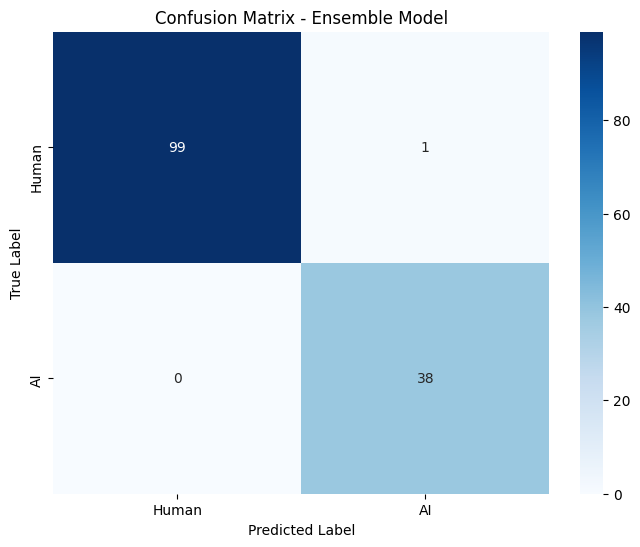


Confusion Matrix:
[[99  1]
 [ 0 38]]


In [13]:
print("\n CREATING OPTIMIZED ENSEMBLE")

# Create voting ensemble with tuned models
ensemble = VotingClassifier(
    estimators=[
        ('rf', best_models['Random Forest']),
        ('gb', best_models['Gradient Boosting']),
        ('lr', best_models['Logistic Regression'])
    ],
    voting='soft',  # Use probability averaging
    weights=[2, 3, 1]  # Give more weight to GB (most consistent)
)

# Train ensemble
print("\n Training ensemble...")
ensemble.fit(X_train, y_train)

# Evaluate
y_pred = ensemble.predict(X_test)
y_pred_proba = ensemble.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
cv_scores = cross_val_score(ensemble, X_train, y_train, cv=5)

print(f"\n✅ ENSEMBLE RESULTS:")
print(f"   Test Accuracy: {accuracy*100:.2f}%")
print(f"   CV Score: {cv_scores.mean()*100:.2f}% (+/- {cv_scores.std()*100:.2f}%)")

print(f"\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Human', 'AI']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Human', 'AI'], 
            yticklabels=['Human', 'AI'])
plt.title('Confusion Matrix - Ensemble Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(f"\nConfusion Matrix:")
print(cm)

**Per-Language Analysis**

In [14]:
print("\n PER-LANGUAGE ACCURACY")

# Get test indices
test_df = df.loc[X_test.index].copy()
test_df['prediction'] = y_pred
test_df['confidence'] = y_pred_proba.max(axis=1)
test_df['correct'] = (test_df['label'] == test_df['prediction'])

# Analyze per language
for lang in sorted(test_df['language'].unique()):
    lang_data = test_df[test_df['language'] == lang]
    if len(lang_data) > 0:
        accuracy = lang_data['correct'].mean()
        avg_conf = lang_data['confidence'].mean()
        print(f"   {lang.capitalize():12} - Accuracy: {accuracy*100:5.1f}% | Avg Confidence: {avg_conf:.2f} | Samples: {len(lang_data)}")

# Check misclassifications
print(f"\n❌ MISCLASSIFIED SAMPLES:")
misclassified = test_df[~test_df['correct']]
if len(misclassified) > 0:
    for idx, row in misclassified.iterrows():
        true_label = "AI" if row['label'] == 1 else "Human"
        pred_label = "AI" if row['prediction'] == 1 else "Human"
        print(f"   {row['filename']:30} | True: {true_label:5} | Pred: {pred_label:5} | Conf: {row['confidence']:.2f} | Lang: {row['language']}")


 PER-LANGUAGE ACCURACY
   English      - Accuracy: 100.0% | Avg Confidence: 0.90 | Samples: 22
   Hindi        - Accuracy: 100.0% | Avg Confidence: 0.99 | Samples: 80
   Malyalam     - Accuracy: 100.0% | Avg Confidence: 0.94 | Samples: 14
   Tamil        - Accuracy: 100.0% | Avg Confidence: 0.95 | Samples: 14
   Telugu       - Accuracy:  87.5% | Avg Confidence: 0.92 | Samples: 8

❌ MISCLASSIFIED SAMPLES:
   human_telugu_1.mp3             | True: Human | Pred: AI    | Conf: 0.86 | Lang: telugu


In [20]:
print("\n TESTING ON PROBLEMATIC SAMPLE")

def predict_with_ensemble(audio_path):
    """Predict using ensemble"""
    features = extract_features(audio_path)
    features_scaled = scaler.transform([features])
    
    prediction = ensemble.predict(features_scaled)[0]
    confidence = ensemble.predict_proba(features_scaled)[0].max()
    
    label = "AI_GENERATED" if prediction == 1 else "HUMAN"
    
    print(f"\nFile: {os.path.basename(audio_path)}")
    print(f"Classification: {label}")
    print(f"Confidence: {confidence:.2%}")
    
    # Show individual model predictions
    print(f"\nIndividual predictions:")
    for name, model in zip(['RF', 'GB', 'LR'], ensemble.estimators_):
        pred = model.predict(features_scaled)[0]
        conf = model.predict_proba(features_scaled)[0].max()
        lbl = "AI" if pred == 1 else "Human"
        print(f"   {name}: {lbl:5} (conf: {conf:.2%})")
    
    return label, confidence

# Test samples
test_samples = [
    r"D:\REHAAN\1. Ml Projects\5. AI Voice Detection\data\ai\ai_sample_1.mp3",
    r"D:\REHAAN\1. Ml Projects\5. AI Voice Detection\data\ai\English\NoteGPT_Speech_1771138144765.mp3",
    r"D:\REHAAN\1. Ml Projects\5. AI Voice Detection\data\ai\English\Recording 2026-02-15 131047.mp3",
    r"D:\REHAAN\1. Ml Projects\5. AI Voice Detection\data\ai\Hindi\HIN AUDIO 11LABS.mp3",
    "D:\REHAAN\1. Ml Projects\5. AI Voice Detection\data\ai\English\eng audio 11labs 2.mp3",
    r"D:\REHAAN\1. Ml Projects\5. AI Voice Detection\data\human\Hindi\common_voice_hi_43599908.mp3",
    r"D:\REHAAN\1. Ml Projects\5. AI Voice Detection\data\human\Telugu\human_telugu_2.mp3"
    
]

for sample in test_samples:
    if os.path.exists(sample):
        predict_with_ensemble(sample)
        print("-" * 60)


 TESTING ON PROBLEMATIC SAMPLE

File: ai_sample_1.mp3
Classification: AI_GENERATED
Confidence: 96.09%

Individual predictions:
   RF: AI    (conf: 88.97%)
   GB: AI    (conf: 100.00%)
   LR: AI    (conf: 98.59%)
------------------------------------------------------------

File: NoteGPT_Speech_1771138144765.mp3
Classification: AI_GENERATED
Confidence: 96.58%

Individual predictions:
   RF: AI    (conf: 90.03%)
   GB: AI    (conf: 100.00%)
   LR: AI    (conf: 99.43%)
------------------------------------------------------------

File: Recording 2026-02-15 131047.mp3
Classification: AI_GENERATED
Confidence: 88.98%

Individual predictions:
   RF: AI    (conf: 66.93%)
   GB: AI    (conf: 100.00%)
   LR: AI    (conf: 100.00%)
------------------------------------------------------------

File: HIN AUDIO 11LABS.mp3
Classification: AI_GENERATED
Confidence: 95.41%

Individual predictions:
   RF: AI    (conf: 87.31%)
   GB: AI    (conf: 100.00%)
   LR: AI    (conf: 97.87%)
----------------------

In [19]:
#SAVING OPTIMIZED MODEL

# Save ensemble model
model_path = r"D:\REHAAN\1. Ml Projects\5. AI Voice Detection\models\voice_detector.pkl"
joblib.dump(ensemble, model_path)
print(f"✅ Ensemble saved: {model_path}")

# Save scaler
scaler_path = r"D:\REHAAN\1. Ml Projects\5. AI Voice Detection\models\scaler.pkl"
joblib.dump(scaler, scaler_path)
print(f"✅ Scaler saved: {scaler_path}")

# Save model info
info_path = r"D:\REHAAN\1. Ml Projects\5. AI Voice Detection\models\model_info.txt"
with open(info_path, 'w') as f:
    f.write("="*60 + "\n")
    f.write("AI VOICE DETECTION - OPTIMIZED MODEL\n")
    f.write("="*60 + "\n\n")
    f.write(f"Model Type: Ensemble (RF + GB + LR)\n")
    f.write(f"Test Accuracy: {accuracy*100:.2f}%\n")
    f.write(f"CV Score: {cv_scores.mean()*100:.2f}% (+/- {cv_scores.std()*100:.2f}%)\n")
    f.write(f"Training Samples: {len(X_train)}\n")
    f.write(f"Test Samples: {len(X_test)}\n")
    f.write(f"Features: {X_train.shape[1]}\n")
    f.write(f"\nBest Hyperparameters:\n")
    f.write(f"Random Forest: {rf_grid.best_params_}\n")
    f.write(f"Gradient Boosting: {gb_grid.best_params_}\n")
    f.write(f"Logistic Regression: {lr_grid.best_params_}\n")
print(f"✅ Model info saved: {info_path}")

print("\nOPTIMIZATION COMPLETE!")

✅ Ensemble saved: D:\REHAAN\1. Ml Projects\5. AI Voice Detection\models\voice_detector.pkl
✅ Scaler saved: D:\REHAAN\1. Ml Projects\5. AI Voice Detection\models\scaler.pkl
✅ Model info saved: D:\REHAAN\1. Ml Projects\5. AI Voice Detection\models\model_info.txt

OPTIMIZATION COMPLETE!
